##Import Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import operator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

##Features

In [0]:
valid_characters = '0123456789.+*-/'

In [0]:
val_char_dict = dict((character, index) for index, character in enumerate(valid_characters))

In [0]:
val_char_dict_inv = dict((index, character) for index, character in enumerate(valid_characters))

##One-Hot Encoder/Decoder

In [0]:
def one_hot_encode(decoded):
  encoded = np.zeros((repeat_steps, len(valid_characters)))
  padding = repeat_steps - len(decoded)

  for index, character in enumerate(decoded):
    encoded[index+padding, val_char_dict[character]] = 1
  
  for index in range(0, padding):
    encoded[index, val_char_dict['0']] = 1
  
  return encoded

In [0]:
def one_hot_decode(encoded):
  decoded = [val_char_dict_inv[np.argmax(array)] for index, array in enumerate(encoded)]
  decoded = ''.join(decoded)
  
  return decoded

##Data Synthesis

In [0]:
number_max = 100 #Up to this number
repeat_steps = len(str(number_max-1)) * 2 + 1

In [0]:
operators = ['+', '*', '-', '/']
operators_dict = { "+":operator.add, 
                  '*':operator.mul, 
                  "-":operator.sub,
                  '/':operator.truediv}

In [0]:
def data_generator():
  number_1 = np.random.randint(1,number_max)
  operator_index = np.random.randint(0,len(operators))
  operator = operators[operator_index]
  number_2 = np.random.randint(1,number_max)
  operation = str(number_1) + operator + str(number_2)
  result = str(round(operators_dict[operator](number_1,number_2),5))
  return operation, result

In [10]:
data_points = 1000000
test_size = 0.2

training_size = int(round(data_points * (1-test_size),0))
test_size = data_points - training_size

x_train = []
x_test = []
y_train = []
y_test = []

for i in tqdm(range(0, training_size)):
  x, y = data_generator()
  x_e = one_hot_encode(x)
  y_e = one_hot_encode(y)
  x_train.append(x_e)
  y_train.append(y_e)

for i in tqdm(range(0, test_size)):
  x, y = data_generator()
  x_e = one_hot_encode(x)
  y_e = one_hot_encode(y)
  x_test.append(x_e)
  y_test.append(y_e)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

##Model

In [0]:
model = Sequential()

model.add(SimpleRNN(units=1024, input_shape=(None, len(valid_characters))))
model.add(RepeatVector(repeat_steps))

model.add(SimpleRNN(units=1024, return_sequences=True))
model.add(TimeDistributed(Dense(units=len(valid_characters), activation='softmax')))


In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy' )

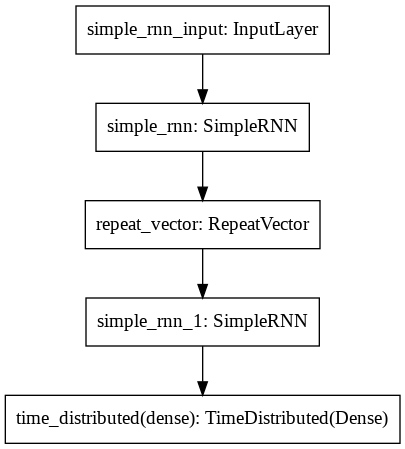

In [13]:
plot_model(model)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1024)              1064960   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 1024)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 5, 1024)           2098176   
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 15)             15375     
Total params: 3,178,511
Trainable params: 3,178,511
Non-trainable params: 0
_________________________________________________________________


In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=25)
save_best = ModelCheckpoint('best_model.hdf5', monitor='val_loss', save_best_only=True, mode='min')

In [16]:
history = model.fit(x_train,
                    y_train, 
                    batch_size=512,
                    epochs=250,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, save_best])

Epoch 1/250
1563/1563 [==============================] - 24s 15ms/step - loss: 0.9445 - accuracy: 0.7160 - val_loss: 0.6698 - val_accuracy: 0.8167
Epoch 2/250
1563/1563 [==============================] - 24s 15ms/step - loss: 0.5585 - accuracy: 0.8534 - val_loss: 0.4560 - val_accuracy: 0.8828
Epoch 3/250
1563/1563 [==============================] - 24s 15ms/step - loss: 0.3665 - accuracy: 0.9073 - val_loss: 0.2964 - val_accuracy: 0.9264
Epoch 4/250
1563/1563 [==============================] - 24s 15ms/step - loss: 0.2538 - accuracy: 0.9361 - val_loss: 0.2363 - val_accuracy: 0.9394
Epoch 5/250
1563/1563 [==============================] - 24s 15ms/step - loss: 0.2130 - accuracy: 0.9460 - val_loss: 0.1781 - val_accuracy: 0.9573
Epoch 6/250
1563/1563 [==============================] - 24s 15ms/step - loss: 0.2013 - accuracy: 0.9478 - val_loss: 0.1615 - val_accuracy: 0.9599
Epoch 7/250
1563/1563 [==============================] - 24s 15ms/step - loss: 0.1966 - accuracy: 0.9482 - val_loss: 0

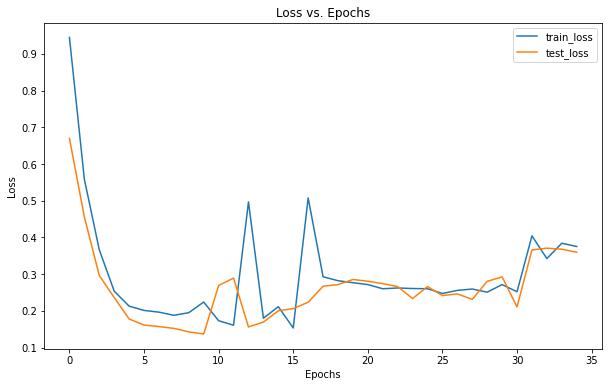

In [52]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(history.history['loss'])), history.history['loss'], label='train_loss')
plt.plot(np.arange(0,len(history.history['val_loss'])), history.history['val_loss'], label='test_loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

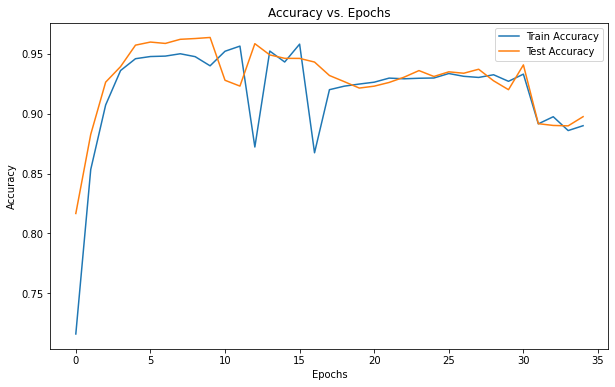

In [53]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(history.history['accuracy'])), history.history['accuracy'], label='Train Accuracy')
plt.plot(np.arange(0,len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

In [0]:
model = load_model('/content/best_model.hdf5')

In [0]:
def predict_result(operation):
  o = one_hot_encode(operation)
  o = np.reshape(o, (1, o.shape[0], o.shape[1] ))
  predictions = model.predict(o)
  for prediction in predictions:
    return one_hot_decode(prediction).lstrip("0")

In [37]:
predict_result('14+7')

'21'

In [39]:
predict_result('99*5')

'495'

In [41]:
predict_result('2/8')

'.125'

In [44]:
predict_result('75-64')

'11'